## Final Project Submission

* Students name: Lucy Munge, Curtis Kariuki and Frank Kiptoo
* Student pace: Part Time
* Instructor name: Stella Waithera


# King County House Sales Analysis & Regression Modeling

# Project Overview

## Business Problem

The real estate agency, Amani is facing a challenge in providing valuable advice to homeowners regarding home renovations. Homeowners often inquire about the potential increase in the estimated value of their homes after making specific renovations or improvements. The agency needs to develop a predictive model that can accurately estimate the impact of various renovation projects on a home's market value within the northwestern county.

The goal is to offer data-driven recommendations to homeowners, enabling them to make informed decisions about which renovations to undertake and how these renovations will affect the resale value of their homes.

The questions to be answered are:
1. How does the number of bedrooms, bathrooms, grade and square footage of a house correlate with its sale price in King County?


## Data Understanding

This project uses the King County House Sales dataset, found in kc_house_data.csv. The file contains information on over 21,000 housing units. The data is organized into a dataframe with several columns containing information on the housing units.
The following are the columns contained in the dataset along with their descriptions:
* id - Unique identifier for a house
* date - Date house was sold
* price - Sale price (prediction target)
* bedrooms - Number of bedrooms
* bathrooms - Number of bathrooms
* sqft_living - Square footage of living space in the home
* sqft_lot - Square footage of the lot
* floors - Number of floors (levels) in house
* waterfront - Whether the house is on a waterfront
Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* view - Quality of view from house
Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* condition - How good the overall condition of the house is. Related to maintenance of house.
See the King County Assessor Website for further explanation of each condition code
* grade - Overall grade of the house. Related to the construction and design of the house.
See the King County Assessor Website for further explanation of each building grade code
* sqft_above - Square footage of house apart from basement
* sqft_basement - Square footage of the basement
* yr_built - Year when house was built
* yr_renovated - Year when house was renovated
* zipcode - ZIP Code used by the United States Postal Service
* lat - Latitude coordinate
* long - Longitude coordinate
* sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
* sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

The columns used in the analysis are:
* price - Predictor Variable
* condition
* bedrooms
* bathrooms
* sqft_living
* floors

In [1]:
#Importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import statsmodels.api as sm
import numpy as np
import scipy.stats as statsmodels

## Data Preparation

In [2]:
# Loading the Data File into a Dataframe
housing_data = pd.read_csv('data/kc_house_data.csv')

In [3]:
# previewing the first 10 rows
housing_data.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,NO,NaN,...,7 Average,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,NO,NONE,...,7 Average,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,NO,NONE,...,7 Average,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [4]:
# check no.or rows and columns
housing_data.shape

(21597, 21)

In [5]:
# check columns names
housing_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
# check the overview of the df
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

From the overview, it can be seen that the all the columns except waterfront, view and yr_renovated have some missing values. The dataframe has 21597 records with varying data types of floats, integers and objects.

In [7]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Check:
    Outliers
    Scatter plots for price against the 4 columns

## Modeling

In [8]:
import statsmodels as sm

In [52]:
housing_new_data = housing_data.drop(['date','id',
       'sqft_lot', 'waterfront', 'view','grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],axis=1)


In [53]:
housing_new_data

,price,bedrooms,bathrooms,sqft_living,floors,condition
0,221900.0,3,1.00,1180,1.0,Average
1,538000.0,3,2.25,2570,2.0,Average
2,180000.0,2,1.00,770,1.0,Average
3,604000.0,4,3.00,1960,1.0,Very Good
4,510000.0,3,2.00,1680,1.0,Average
...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,3.0,Average
21593,400000.0,4,2.50,2310,2.0,Average
21594,402101.0,2,0.75,1020,2.0,Average
21595,400000.0,3,2.50,1600,2.0,Average


## Visualization

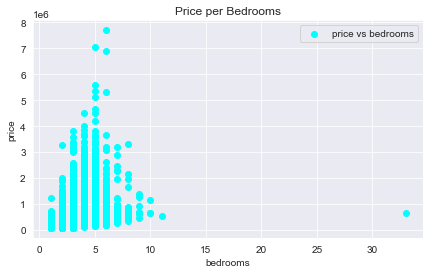

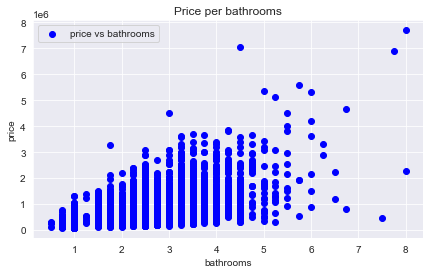

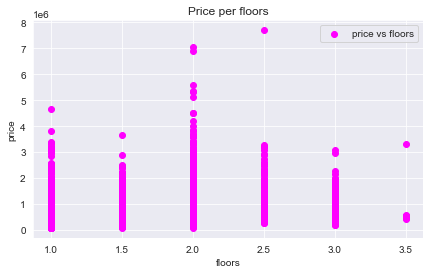

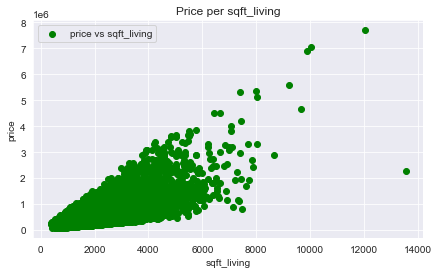

In [55]:
# Create 2 plots showing the corr between the price and(bedrooms , bathrooms , sqft_living , floors)
plt.figure(figsize=(7,4))
plt.scatter(data=housing_new_data, x='bedrooms', y='price', color='cyan')

plt.xlabel('bedrooms')
plt.ylabel('price')
plt.title('Price per Bedrooms')
plt.legend(['price vs bedrooms'])
plt.show();

plt.figure(figsize=(7,4))
plt.scatter(data=housing_new_data, x='bathrooms', y='price', color='blue')

plt.xlabel('bathrooms')
plt.ylabel('price')
plt.title('Price per bathrooms')
plt.legend(['price vs bathrooms'])
plt.show();

plt.figure(figsize=(7,4))
plt.scatter(data=housing_new_data, x='floors', y='price', color='magenta')

plt.xlabel('floors')
plt.ylabel('price')
plt.title('Price per floors')
plt.legend(['price vs floors'])
plt.show();

plt.figure(figsize=(7,4))
plt.scatter(data=housing_new_data, x='sqft_living', y='price', color='green')

plt.xlabel('sqft_living')
plt.ylabel('price')
plt.title('Price per sqft_living')
plt.legend(['price vs sqft_living'])
plt.show();

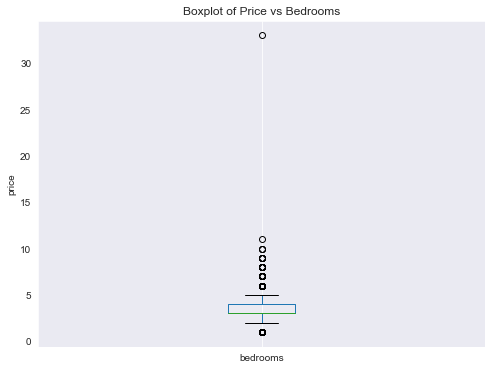

In [61]:
# Create a boxplot for all columns
plt.figure(figsize=(8, 6))
housing_new_data.boxplot(column='bedrooms')
plt.title('Boxplot of Price vs Bedrooms')
plt.ylabel('price')

  
plt.grid(axis='y')  # Add a horizontal grid

# Show the boxplot
plt.show()


In [62]:
housing_new_data.describe()

,price,bedrooms,bathrooms,sqft_living,floors
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.494096
std,3.673681e+05,0.926299,0.768984,918.106125,0.539683
min,7.800000e+04,1.000000,0.500000,370.000000,1.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,1.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,1.500000
75%,6.450000e+05,4.000000,2.500000,2550.000000,2.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,3.500000
